## Submission for BHI 2023 Public Health Informatics Data Competition
*CAN US aggregate timeseries dataset*

#### Imports

In [2]:
import pandas as pd
import torch

#### Load Dataframes & Sub-set Data

In [20]:
df = pd.read_csv("../data/US.timeseries.csv")

df = df.loc[:, ["date", "actuals.newCases"]].dropna()

df

,date,actuals.newCases
3,2020-03-12,403.0
4,2020-03-13,542.0
5,2020-03-14,673.0
6,2020-03-15,699.0
7,2020-03-16,906.0
...,...,...
1153,2023-05-06,0.0
1154,2023-05-07,0.0
1155,2023-05-08,0.0
1156,2023-05-09,0.0


#### Plot time-series

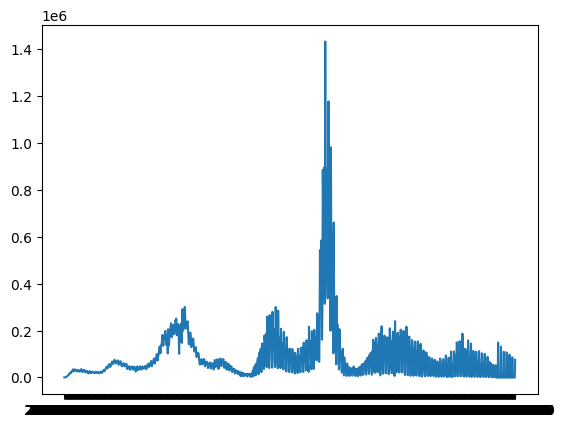

In [22]:
import matplotlib.pyplot as plt

plt.plot(df["date"], df["actuals.newCases"])
plt.show()

#### Train/Test Split
train <= 09-26-21

test >= 09-27-21

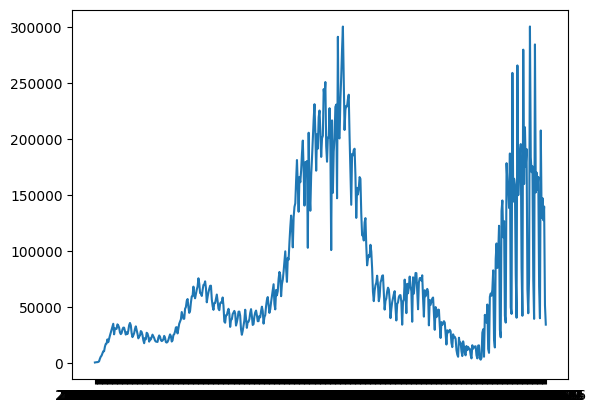

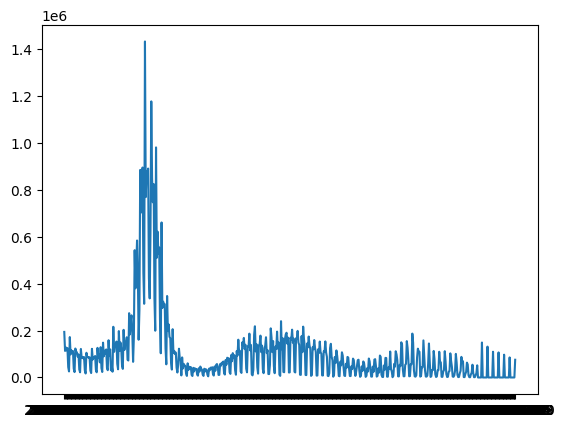

In [84]:
train, test = df[df['date'] <= '2021-09-26'], df[df['date'] >= '2021-09-27']

plt.plot(train["date"], train["actuals.newCases"])
plt.show()

plt.plot(test["date"], test["actuals.newCases"])
plt.show()

train = train.reset_index()
train = train['actuals.newCases'].values.astype('float32')
test = test.reset_index()
test = test['actuals.newCases'].values.astype('float32')

### Look-back function

In [92]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    print(X, y)
    return torch.tensor(X), torch.tensor(y)


lookback = 7
X_train, y_train = create_dataset(train.to_numpy().T, lookback=lookback)
X_test, y_test = create_dataset(test.to_numpy().T, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

[array([ 403.,  542.,  673.,  699.,  906., 1398., 3785.], dtype=float32), array([ 542.,  673.,  699.,  906., 1398., 3785., 5544.], dtype=float32), array([ 673.,  699.,  906., 1398., 3785., 5544., 6515.], dtype=float32), array([ 699.,  906., 1398., 3785., 5544., 6515., 8522.], dtype=float32), array([  906.,  1398.,  3785.,  5544.,  6515.,  8522., 10430.],
      dtype=float32), array([ 1398.,  3785.,  5544.,  6515.,  8522., 10430., 10430.],
      dtype=float32), array([ 3785.,  5544.,  6515.,  8522., 10430., 10430., 14490.],
      dtype=float32), array([ 5544.,  6515.,  8522., 10430., 10430., 14490., 16981.],
      dtype=float32), array([ 6515.,  8522., 10430., 10430., 14490., 16981., 17324.],
      dtype=float32), array([ 8522., 10430., 10430., 14490., 16981., 17324., 21060.],
      dtype=float32), array([10430., 10430., 14490., 16981., 17324., 21060., 18515.],
      dtype=float32), array([10430., 14490., 16981., 17324., 21060., 18515., 21460.],
      dtype=float32), array([14490., 1698

#### LTSM Neural Network Definition

In [70]:
import torch.nn as nn
 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

#### Training Loop

In [71]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data

mps = torch.device('mps')

model = Net()
model.to(mps)

X_train = X_train.to(mps)
y_train = y_train.to(mps)

X_test = X_test.to(mps)
y_test = y_test.to(mps)


optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, torch.div(train_rmse, torch.mean()), test_rmse))

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 7